# Predicting likelihood of job automation

Mike Griffin

In [250]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (RBF,RationalQuadratic)
import matplotlib.pyplot as plt
%matplotlib inline

## Calibrating against 2010 analysis

In [251]:
ML_data = pd.read_csv("ML_data_2010.csv") 

In [252]:
ML_data.head()

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML
0,11-1011,Chief Executives,0.29,2.13,0.00,4.38,4.50,4.50,5.00,2.42,1.47,0.0,0.015
1,11-1021,General and Operations Managers,0.06,2.75,2.25,3.62,3.50,3.25,3.50,3.60,1.32,NaN,0.160
2,11-2011,Advertising and Promotions Managers,3.51,1.75,0.62,3.75,3.75,3.75,3.62,1.91,1.53,NaN,0.039
3,11-2021,Marketing Managers,1.52,1.75,0.00,4.12,4.00,4.00,4.25,2.44,1.21,NaN,0.014
4,11-2022,Sales Managers,0.50,2.12,1.62,4.25,3.88,4.12,4.25,2.30,1.33,NaN,0.013


In [253]:
ML_data.shape

(715, 13)

## Train model on labelled data

In [254]:
ML_train = ML_data[ML_data['label_ML']>=0]
ML_train.head()

,OCC_CODE,OCC_TITLE,fine_arts,finger_dexterity,manual_dexterity,social_perceptiveness,Negotiation,Originality,Persuasion,assisting_and_caring,cramped_work_space,label_ML,probability_ML
0,11-1011,Chief Executives,0.290000,2.130,0.000000,4.380000,4.500,4.500000,5.000000,2.420000,1.470000,0.0,0.0150
11,11-3071,"Transportation, Storage, and Distribution Mana...",0.186667,1.790,0.626667,3.750000,3.540,3.126667,3.456667,2.533333,1.286667,0.0,0.5900
28,11-9151,Social and Community Service Managers,1.220000,2.250,0.000000,4.750000,3.750,4.120000,3.880000,5.510000,1.600000,0.0,0.0067
35,13-1031,"Claims Adjusters, Examiners, and Investigators",0.175000,2.315,1.185000,3.250000,3.685,2.500000,3.190000,2.320000,1.360000,1.0,0.9800
37,13-1041,Compliance Officers,0.111667,2.710,1.668333,3.683333,3.145,3.315000,3.438333,3.248333,1.933333,0.0,0.0800


In [255]:
features = ['fine_arts','finger_dexterity','manual_dexterity','social_perceptiveness','Negotiation','Originality','Persuasion','assisting_and_caring','cramped_work_space']

X_train = ML_train.filter(features)
y_train = ML_train.filter(['label_ML'])

In [256]:
X_all = ML_data.filter(features)

In [257]:
X_train = X_train
print(X_train.shape)
print(ML_data.shape)

(68, 9)
(715, 13)


In [258]:
#kernel = 1.0 * RBF(1.0)
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)
gpc.score(X_train, y_train)

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9558823529411765

## Run model on all occupations

In [259]:
GP_est = pd.DataFrame(gpc.predict_proba(X_all))

In [260]:
ML_output = pd.concat([ML_data,GP_est],axis=1,ignore_index= True)

In [261]:
ML_output.columns = ['OCC_CODE','OCC_TITLE','fine_arts','finger_dexterity',
                     'manual_dexterity','social_perceptiveness','Negotiation',
                     'Persuasion','Originality','assisting_and_caring','cramped_work_space',
                     'label_ML','probability_ML','GP_pred_0','GP_pred_1']

## Analyse results against original study 

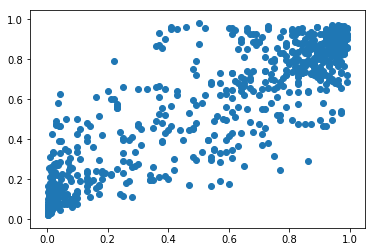

In [262]:
plt.scatter(ML_output['probability_ML'], ML_output['GP_pred_1'])

In [263]:
# Assign classifications

def prob_class_old(row):
    if row["probability_ML"] < 0.3:
        return "3) Low"
    elif row["probability_ML"] < 0.6:
        return "2) Medium"
    else:
        return "1) High"

def prob_class_new(row):
    if row["GP_pred_1"] < 0.3:
        return "3) Low"
    elif row["GP_pred_1"] < 0.6:
        return "2) Medium"
    else:
        return "1) High"


In [264]:
ML_output_mod = ML_output.assign(prob_class_old=ML_output.apply(prob_class_old, axis=1))
ML_output_mod = ML_output_mod.assign(prob_class_new=ML_output_mod.apply(prob_class_new, axis=1))

In [265]:
ML_output_mod.groupby(['prob_class_old','prob_class_new']).size()

prob_class_old  prob_class_new
1) High         1) High           331
                2) Medium          48
                3) Low             17
2) Medium       1) High            31
                2) Medium          43
                3) Low             16
3) Low          1) High             7
                2) Medium          40
                3) Low            182
dtype: int64

## Running same model on 2018 dataset

In [266]:
ML_data_2018 = pd.read_csv("ML_data_2018.csv")
column_names_2018 = ML_data_2018.columns.values.tolist()

In [267]:
X_all_2018 = ML_data_2018.filter(features)
GP_est_2018 = pd.DataFrame(gpc.predict_proba(X_all_2018))
ML_output_2018 = pd.concat([ML_data_2018,GP_est_2018],axis=1,ignore_index= True)
ML_output_2018.columns = column_names_2018+ ['GP_pred_0','GP_pred_1']

In [268]:
ML_output_2018_mod = ML_output_2018.assign(prob_class_new=ML_output_2018.apply(prob_class_new, axis=1))

In [269]:
ML_output_2018_mod.head()

,OCC_CODE,cognitive_abilities,physical_abilities,psychomotor_abilities,sensory_abilities,assisting_and_caring,cramped_work_space,fine_arts,finger_dexterity,manual_dexterity,Negotiation,Originality,Persuasion,social_perceptiveness,GP_pred_0,GP_pred_1,prob_class_new
0,11-1011,3.242865,0.013889,0.456,1.837083,2.275,1.415,0.915,2.00,0.00,3.935,4.125,4.44,3.935,0.926849,0.073151,3) Low
1,11-1021,3.026486,1.026667,1.137,1.928333,2.950,1.530,0.470,1.38,0.75,3.620,3.380,3.50,4.000,0.859625,0.140375,3) Low
2,11-2011,2.799027,0.097778,0.287,1.780833,2.000,1.380,2.300,1.12,0.38,3.750,3.880,3.88,4.000,0.915966,0.084034,3) Low
3,11-2021,2.882757,0.125556,0.212,1.792500,2.210,1.200,1.320,1.25,0.00,3.880,4.000,4.38,4.000,0.929223,0.070777,3) Low
4,11-2022,2.958811,0.153333,0.523,1.812500,2.610,1.390,0.610,1.25,0.62,3.880,3.880,4.38,4.120,0.949928,0.050072,3) Low


In [270]:
ML_output_2018_mod.to_csv('ML_output_2018.csv')